<a href="https://colab.research.google.com/github/Lutris98/21_1Q/blob/master/1.Titanic/Titanic_Prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.EDA

In [589]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV #model_selection doesn't need mentioning, only the method does
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score #given metric was accuracy

In [590]:
from google.colab import drive #Korean Army banned me from using os resources so I learned new ways
drive.mount('/content/gdrive')
titanic_df=pd.read_csv('/content/gdrive/MyDrive/Dataset/titanic_train.csv')
test_df=pd.read_csv('/content/gdrive/MyDrive/Dataset/titanic_test.csv') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [591]:
test_df['Survived']=2
df=pd.concat([titanic_df,test_df],axis=0) #concatenating method in Pandas #Preprocessing needs test data(Never modeling) #Null values are okay until padding

##1)Basic Statistics

In [592]:
df.head(3) 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [593]:
df.info() #objects are strings

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 132.9+ KB


##2)Encoding

In [594]:
df['Cabin']=df['Cabin'].str[:1] #Cabin needs insight that only the first character contains information #pd.str is applicable to series
df.loc[(df.Embarked.isna()==True),'Embarked']='S'
features=['Cabin','Sex','Embarked']
for feature in features:
  df[feature]=LabelEncoder().fit_transform(df[feature].astype(str)) #changing dtype of series #all are ordered categories
  print(df[feature].value_counts(sort=True)) #focusing on columns

8    1014
2      94
1      65
3      46
4      41
0      22
5      21
6       5
7       1
Name: Cabin, dtype: int64
1    843
0    466
Name: Sex, dtype: int64
2    916
0    270
1    123
Name: Embarked, dtype: int64


##3)Basic feature engineering

In [595]:
df['Family']=df['SibSp']+df['Parch'] #Each feature doesn't mean much on its own
df=df.drop(['SibSp','Parch','Ticket'], axis=1) #drop method doesn't allow inplacing(Should check results along the way)
df['Name']=df['Name'].str.extract('([A-Za-z]+)\.') #easiest Regex([] contains letters, +groups the previous part, ()contains part to be remembered, \ignores that . mean any letters)
df['Name'].value_counts(sort=True) #Even the most worthless data needs a peak

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Major         2
Mlle          2
Ms            2
Mme           1
Don           1
Capt          1
Sir           1
Countess      1
Lady          1
Jonkheer      1
Dona          1
Name: Name, dtype: int64

In [596]:
df['Name'].replace(['Rev','Dr','Col','Major','Sir','Don','Mlle','Jonkheer','Mme','Ms','Countess','Capt','Lady','Dona'],['Mr','Mr','Mr','Mr','Mr','Mr','Mr','Mr','Mr','Miss','Miss','Miss','Miss','Miss',],inplace=True) #last3 of Mr is just guessing
df['Name'].value_counts(sort=True)

Mr        785
Miss      266
Mrs       197
Master     61
Name: Name, dtype: int64

In [597]:
df['Name']=LabelEncoder().fit_transform(df['Name'])
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Fare,Cabin,Embarked,Family
0,1,0,3,2,1,22.0,7.2500,8,2,1
1,2,1,1,3,0,38.0,71.2833,2,0,1
2,3,1,3,1,0,26.0,7.9250,8,2,0
3,4,1,1,3,0,35.0,53.1000,2,2,1
4,5,0,3,2,1,35.0,8.0500,8,2,0


#2.Preprocessing(with Visualization)

##1)Imputation

In [598]:
df.loc[(df.Age.isnull())&(df.Name==2),'Age']=40 #Another way to load series object #inside []are all true
df.loc[(df.Age.isnull())&(df.Name==3),'Age']=40
df.loc[(df.Age.isnull())&(df.Name==1),'Age']=20
df.loc[(df.Age.isnull())&(df.Name==0),'Age']=5
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
Fare           1
Cabin          0
Embarked       0
Family         0
dtype: int64

##2)Binning

In [599]:
df['Age_band']=0 #for float data in classification
df.loc[df.Age<=15, 'Age_band']=1
df.loc[(df.Age>15)&(df.Age<=30), 'Age_band']=2
df.loc[(df.Age>30)&(df.Age<=45), 'Age_band']=3
df.loc[(df.Age>45)&(df.Age<=60), 'Age_band']=4
df.loc[(df.Age>60)&(df.Age<=75), 'Age_band']=5
df.loc[(df.Age>75)&(df.Age<=90), 'Age_band']=6

In [600]:
df['Fare_band']=0 #by describe method
df.loc[df.Fare<=7, 'Fare_band']=1
df.loc[(df.Fare>14)&(df.Fare<=28), 'Fare_band']=2
df.loc[(df.Fare>28)&(df.Fare<=35), 'Fare_band']=3
df.loc[(df.Fare>35), 'Fare_band']=4

In [601]:
df.drop(['Age','Fare'],axis=1,inplace=True)

##3)Feature selection

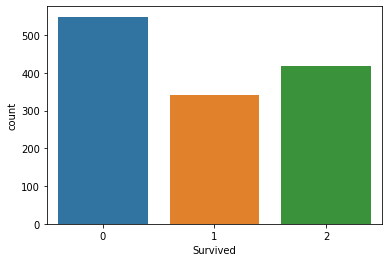

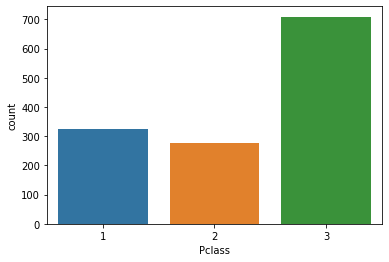

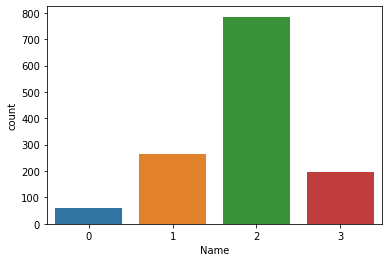

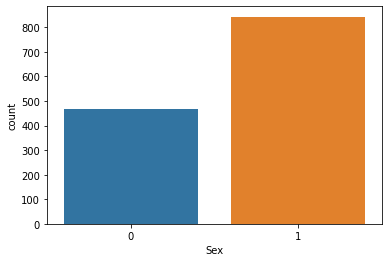

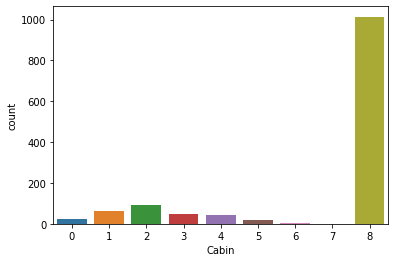

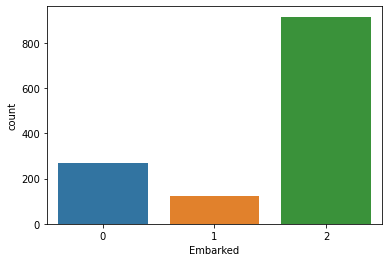

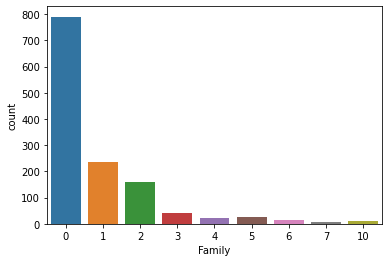

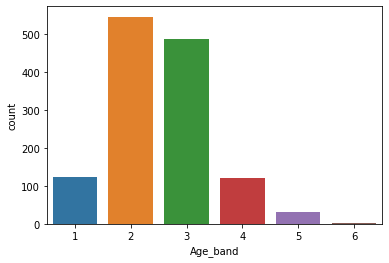

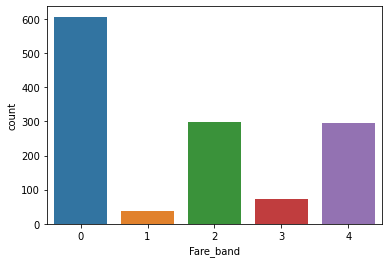

In [602]:
pre_df=df.drop(['PassengerId'], axis=1)
features=pre_df.columns.values #columns is dataframe, so make it into ndarray #1.Feature distribution/train&test similarity
for feature in features: #now i get why ppl use enumerate
    plt.figure() #to control manually we need subplots and ax
    sns.countplot(data=pre_df,x=feature) #sns has advantages on graph by dataframe(not x,y but data and feature names) 
    plt.xlabel(feature)

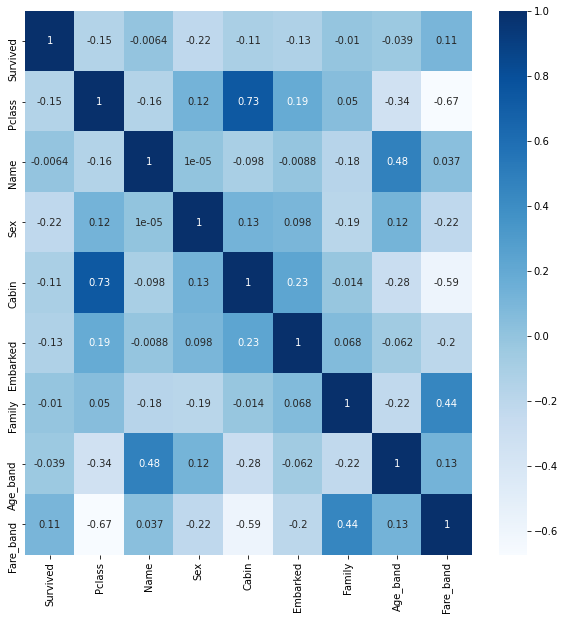

In [603]:
plt.figure(figsize=(10,10))
sns.heatmap(pre_df.corr(), annot=True, cmap='Blues') #annotation is a must #2.Correlation

In [604]:
cabin_df=pre_df.groupby(['Pclass','Cabin']).size() #always groupby 2features, use with size()
cabin_df

Pclass  Cabin
1       0         22
        1         65
        2         94
        3         40
        4         34
        7          1
        8         67
2       3          6
        4          4
        5         13
        8        254
3       4          3
        5          8
        6          5
        8        693
dtype: int64

In [605]:
df.loc[(df.Cabin==8)&(df.Pclass==1),'Cabin']=2
df.loc[(df.Cabin==8)&(df.Pclass==2),'Cabin']=4
df.loc[(df.Cabin==8)&(df.Pclass==3),'Cabin']=6

#3.CV&Tuning

In [606]:
test_df=df.loc[df['Survived']==2].drop('Survived',axis=1) #Needs division again
titanic_df=df.loc[df['Survived']!=2]
titanic_feature=titanic_df.drop(['Survived','PassengerId'], axis=1) #parameter axis is mandatory
titanic_label=titanic_df['Survived']
titanic_feature.head(3)

,Pclass,Name,Sex,Cabin,Embarked,Family,Age_band,Fare_band
0,3,2,1,6,2,1,2,0
1,1,3,0,2,0,1,3,4
2,3,1,0,6,2,0,2,0


In [607]:
rf_clf=RandomForestClassifier(random_state=0) #Cross validation need models 
xgb_clf=XGBClassifier(random_state=0)
svm_clf=SVC(kernel='rbf',C=0.1,probability=True)
log_clf=LogisticRegression(C=0.1)
X_train, X_test, y_train, y_test=train_test_split(titanic_feature, titanic_label, test_size=0.2,random_state=0)

In [608]:
rf_params={'n_estimators':[50,100,150],
           'max_depth':[3,5,7], #similar to decisiontree
           'min_samples_leaf':[3,5,7],
           'min_samples_split':[5,7,9]}
rf_gridcv=GridSearchCV(rf_clf, param_grid=rf_params, cv=5, n_jobs=-1) #using all CPU cores
rf_gridcv.fit(X_train, y_train)
print('best parameters:\n',rf_gridcv.best_params_)
rf_clf=rf_gridcv.best_estimator_

best parameters:
 {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 150}


In [609]:
xgb_params={'learning_rate' : [0.02], 
            'n_estimators':[200,300,400],
            'max_depth':[3,5,7],
            'colsample_bytree':[0.7,0.8],
            'subsample':[0.9]}
xgb_gridcv=GridSearchCV(xgb_clf, param_grid=xgb_params, cv=5, n_jobs=-1) 
xgb_gridcv.fit(X_train, y_train)
print('best parameters:\n',xgb_gridcv.best_params_)
xgb_clf=xgb_gridcv.best_estimator_

best parameters:
 {'colsample_bytree': 0.8, 'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}


#4.Modeling

In [610]:
vo_clf=VotingClassifier(estimators=[('RandomForest',rf_clf),('XGBoost',xgb_clf),('SVM',svm_clf),('LogisticReg',log_clf)], voting='soft')
pred1=rf_clf.fit(X_train, y_train).predict(X_test)
pred2=xgb_clf.fit(X_train, y_train).predict(X_test)
pred3=svm_clf.fit(X_train, y_train).predict(X_test)
pred4=log_clf.fit(X_train, y_train).predict(X_test)
pred5=vo_clf.fit(X_train, y_train).predict(X_test)
print('Accuracy1:{0:.4f} / Accuracy2:{1:.4f} / Accuracy3:{2:4f} / Accuracy4:{3:4f}'.format(accuracy_score(y_test,pred1), accuracy_score(y_test,pred2),accuracy_score(y_test,pred3),accuracy_score(y_test,pred4)))
print('Final accuracy:{0:.4f}'.format(accuracy_score(y_test,pred5))) #from python3.6 should use fstring formatting  #:separates index and the number

Accuracy1:0.8156 / Accuracy2:0.8101 / Accuracy3:0.787709 / Accuracy4:0.798883
Final accuracy:0.8268


# 1)Uploading

In [611]:
Pid=test_df['PassengerId']
test_df.drop('PassengerId',axis=1,inplace=True)
test_df.head(3)

,Pclass,Name,Sex,Cabin,Embarked,Family,Age_band,Fare_band
0,3,2,1,6,1,0,3,0
1,3,3,0,6,2,1,4,1
2,2,2,1,4,1,0,5,0


In [612]:
realpred=vo_clf.predict(test_df) #output of classifier is ndarray object
realpred=pd.DataFrame(realpred, columns=['Survived']) #never forget[]
submit_df=pd.DataFrame({'PassengerId':Pid,'Survived':realpred['Survived']}) #Data set by giving each column name and data
submit_df.head(3)
submit_df.to_csv('/content/gdrive/MyDrive/Dataset/Lutris_titanic.csv', index = False) #The client doesn't want indice on submission

# 2)Feedback<br>
Do not be satisfied with the comfort higher APIs give. Only the ones that understand the lower ver have the right to enjoy.

#3)Afterwords
I thought about this notebook for a week but barely made it to top33%.<br>
My first competition left me a bit of a warning that things aren't gonna be as rosy as I might dream.<br>
After pouring much thought into it, i skimmed through famous notebooks, but it brought me more despair as I found out that there much simpler notebooks sometimes get much higher scores(that I can't see why), and some I can't understand at my level.<br>
But again, this is a warning. I'm gonna need all the skills I regarded unnecessary, and gonna need read alot. 
There is a bright side. I did learn a lot from this prediction. How I should concatenate train&test data, how important Visualization and Padding can be and so forth.<br>
